# **README**

- this code already inclusdes the URL dataset path to download:
- TMDB Dataset : https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9
- MovieLens Dataset : http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
- Only need to click "Run" button for each Cells (There are 4 Cells: Demographic, Content-based, Collaborative, and Hybrid) to Execute the Codes


In [ ]:
#######################
# PART 1 : DEMOGRAPHIC FILTERING
######################

!pip install gdown
import gdown
gdown.download(f'https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9', quiet=False)
import pandas as pd
import numpy as np
from IPython.display import display, HTML, Image

class DemographicFiltering:
  def __init__(self,data):
    self.df = pd.read_csv(data)

  def recommend(self, genre=None, duration=None, year=None, topk=50):
    df = self.df.copy()
    df_demographic_raw = self.demographic_filter(df, genre=genre, duration=duration, year=year)
    df_imdb_raw = self.compute_imdb_score(df_demographic_raw)
    result = df_imdb_raw

    # Process demographic dataframe
    df_demographic = df_demographic_raw.sort_values("vote_average", ascending=False).head(topk)
    df_demographic['poster_path'] = 'https://image.tmdb.org/t/p/w300_and_h450_bestv2/' + df_demographic['poster_path'].astype(str)
    cols = ['poster_path'] + [col for col in df_demographic if col != 'poster_path']
    df_demographic = df_demographic[cols]

    # Process IMDB dataframe
    df_imdb = result.sort_values("score", ascending=False).head(topk)
    df_imdb['poster_path'] = 'https://image.tmdb.org/t/p/w300_and_h450_bestv2/' + df_imdb['poster_path'].astype(str)
    cols = ['poster_path'] + [col for col in df_imdb if col != 'poster_path']
    df_imdb = df_imdb[cols]

    df_pipeline_1 = df_imdb

    return df_demographic, df_imdb, df_pipeline_1

  #independent static function, not 'self', but inside the class of DemographicFiltering
  @staticmethod
  def demographic_filter(df, genre=None, duration=None, year=None):
    # Start with the whole DataFrame
    filtered_df = df.copy()

    # Apply filtering based on genre if genre is provided
    if genre is not None:
      filtered_df = filtered_df[
          filtered_df['genres'].fillna('').apply(lambda x: all(g in x.split(', ') for g in genre))
        ]

    # Apply filtering based on duration if duration is provided
    if duration is not None:
      filtered_df = filtered_df[
          filtered_df['runtime'].between(duration[0], duration[1])
        ]

    # Apply filtering based on year if year is provided
    if year is not None:
      filtered_df = filtered_df[
          pd.to_datetime(filtered_df['release_date']).dt.year.between(year[0], year[1])
        ]

    return filtered_df

  @staticmethod
  def compute_imdb_score(df, percentile_threshold=0.95):
    # Make a copy to keep original data intact
    df = df.copy()

    # Remove rows where imdb_votes or imdb_rating are NaN
    df = df.dropna(subset=['imdb_votes', 'imdb_rating'])

    # Calculate percentile of imdb_votes
    m = np.percentile(df.imdb_votes, 80)

    # Calculate the weighted average of imdb_rating
    C = (df.imdb_rating * df.imdb_votes).sum() / df.imdb_votes.sum()
    # Filter out movies with imdb_votes less than the threshold m
    df = df[df.imdb_votes >= m]
    # Calculate the weighted score for each movie
    df["score"] = df.apply(lambda x: (x.imdb_rating * x.imdb_votes + C * m) / (x.imdb_votes + m), axis=1)
    return df

def display_with_images(df, title):
    display(HTML(f'<h1 style="background-color:red; color: white; padding: 5px 5px 5px 5px;">{title}</h1>'))

    # Create a new dataframe with image HTML
    display_df = df.copy()
    display_df['poster_path'] = display_df['poster_path'].apply(
        lambda x: f'<img src="{x}" width="100" height="150">' if pd.notnull(x) else ''
    )

    # Display the dataframe
    display(HTML(display_df.to_html(escape=False)))

'''
------------------------------------------------------
TEST ABOVE CODE:
------------------------------------------------------
'''

recsys = DemographicFiltering(data="TMDB_all_movies.csv")

df_demographic, df_imdb, df_pipeline_1 = recsys.recommend(
    genre=["Action", "Adventure", "Science Fiction"],
    duration=(60,150),
    year=(2000,2019)
)

# Display demographic filtering results
df_demographic_show = df_demographic.apply(lambda col: col.str[:100] if col.dtype == 'object' else col)
display_with_images(df_demographic_show, "DEMOGRAPHIC FILTERING (ORIGINAL)")

# Display IMDB weighted results
df_imdb_show = df_imdb.apply(lambda col: col.str[:100] if col.dtype == 'object' else col)
display_with_images(df_imdb_show, "DEMOGRAPHIC FILTERING (WITH IMDB WEIGHTED SCORING)")



Downloading...
From (original): https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9
From (redirected): https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9&confirm=t&uuid=d6ae550a-2b4b-41a9-9b7b-e4d221d4071c
To: /content/TMDB_all_movies.csv
100%|██████████| 636M/636M [00:10<00:00, 61.2MB/s]


,poster_path,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes
574359,,803182,Moon Men,10.000,2.0,Released,2017-01-02,5.500000e+02,148.0,3.0,NaN,en,Moon Men,"Adrian, Sumner, and Cody live greasy, weird lives down in the south land of Arkansas. Part documenta",0.921,"Greetings, from the Summer Of Grease!","Action, Adventure, Comedy, Documentary, Horror, Thriller, Science Fiction",NaN,NaN,English,"Cody Long, Matt Prine, Adrian Beqiri, Dmitri Pejakovich, Sumner Hitchcox",Adrian Beqiri,NaN,NaN,NaN,NaN,NaN,NaN
649216,,912223,Los Vengadores Chiflados,10.000,1.0,Released,2014-01-03,0.000000e+00,65.0,60.0,NaN,es,Los Vengadores Chiflados,Parody of The Avengers (2012) made with action figures.,0.896,NaN,"Comedy, Action, Adventure, Science Fiction",Jepchu Producciones,Mexico,Español,"Negas, Jesús Zavala, Weena Mercator, Milton Wolch, Yotzmit Ramirez",Jesús Zavala,NaN,Jesús Zavala,NaN,NaN,NaN,NaN
410543,,584605,Kamen Rider Kuuga: Special Edition,10.000,1.0,Released,2001-10-21,0.000000e+00,61.0,0.0,NaN,ja,仮面ライダークウガ 特別篇,"A group of archaeologists open a tomb that awakens horrible monsters, while journeyman Yusuke Godai",3.848,NaN,"Action, Adventure, Science Fiction","Toei Company, Ishimori Productions",Japan,日本語,"Kazumi Murata, Shingo Katsurayama, Yuka Takeshima, Wakana Chizaki, Katsuaki Nishide, Joe Odagiri",Hidenori Ishida,NaN,Naruhisa Arakawa,NaN,NaN,NaN,NaN
280798,,417909,Armor Hero Atlas,10.000,1.0,Released,2014-10-01,5.000000e+06,92.0,0.0,tt6448092,zh,铠甲勇士之雅塔莱斯,Duanmu and Lingling uncovers a plan to create an army of mutated creatures to threaten society. As t,1.239,NaN,"Adventure, Action, Drama, Science Fiction","Guangzhou Alpha Media, Beijing Enlight Pictures, Huaxia Film Distribution",China,普通话,"Xu Feng, Cao Xiyue, Wu Yonggan, Geng Yi, Li Xinze, Kenny Zeng, Honglei Li, Zhu Jiaqi, Long Nv",Zheng Guo-Wei,NaN,NaN,NaN,NaN,7.5,20.0
799192,,1126674,The Gunner,10.000,1.0,Released,2015-11-01,0.000000e+00,61.0,0.0,NaN,en,The Gunner,"Before the era of the Laser Men resistance, an ambitious warrior with the help of his partners, look",2.792,"Sometimes you're ready for the future, but it's not ready for you.","Action, Adventure, Science Fiction","5 Cousins Productions, Grimes Road Studios, Luke Schaefer TV",United States of America,English,"Brady Pascoe, Luke Schaefer, Joseph Bondarchuk, Ryan Malek, Jason He, Brandon Nolen, Michael Laird,",Luke Schaefer,Brandon Nolen,"Luke Schaefer, Ryan Malek","Luke Schaefer, Ryan Malek, Brandon Nolen, James Laird, Matthew Schaefer",NaN,NaN,NaN
374256,,535401,Transformers: Power of the Primes,9.143,14.0,Released,2018-05-01,0.000000e+00,102.0,0.0,tt7856082,en,Transformers: Power of the Primes,"In the aftermath of the Titans' conflict that concluded into Optimus Prime's death, the rest of the",2.335,A new Prime shall be chosen,"Action, Animation, Adventure, Science Fiction","Machinima, Inc., Tatsunoko Production, Hasbro Studios",United States of America,English,"Wil Wheaton, Frank Todaro, Jason Marnocha, Matthew Patrick, Mark Hamill, Ron Perlman, Patrick Seitz,",Yuuzou Satou,NaN,"Jamie Iracleanos, Adam Beechen, F.J. DeSanto","Eric S. Calderon, F.J. DeSanto",NaN,6.0,312.0
624767,,873627,Stargate Atlantis: Fans' Choice,9.000,3.0,Released,2009-08-04,0.000000e+00,134.0,0.0,NaN,en,Stargate Atlantis: Fans' Choice,"The exhilarating, feature-length pilot episode, ""Rising"", sends a brilliant team of scientists throu",4.495,NaN,"Action, Adventure, Science Fiction, Drama",NaN,NaN,English,"Kavan Smith, Mitch Pileggi, Michael Shanks, Andee Frizzell, Garwin Sanford, Christopher Heyerdahl, J","Andy Mikita, Martin Wood",NaN,"Paul Mullie, Joseph Mallozzi, Brad Wright, Robert C. Cooper",NaN,NaN,NaN,NaN
1002387,,1370629,Slugterra: Eastern Caverns,9.000,1.0,Released,2015-08-15,0

,poster_path,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,score
16347,,27205,Inception,8.400,37104.0,Released,2010-07-15,8.390306e+08,148.0,160000000.0,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his target",90.553,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pictures","United Kingdom, United States of America","English, Français, 日本語, Kiswahili","Miranda Nolan, Alex Lombard, Joseph Gordon-Levitt, Angela Nathenson, Taylor Geare, Peter Basham, Ken",Christopher Nolan,Wally Pfister,Christopher Nolan,"Yoshikuni Taki, Kanjirô Sakura, Chris Brigham, Christopher Nolan, Emma Thomas, Luke Mendes, Thomas T",Hans Zimmer,8.8,2656135.0,8.748025
183554,,299536,Avengers: Infinity War,8.200,30220.0,Released,2018-04-25,2.052415e+09,149.0,300000000.0,tt4154756,en,Avengers: Infinity War,As the Avengers and their allies have continued to protect the world from threats too large for any,180.047,An entire universe. Once and for all.,"Adventure, Action, Science Fiction",Marvel Studios,United States of America,"English,","Chris Evans, Tom Hiddleston, Idris Elba, Monique Ganderton, Jacob Batalon, Michael James Shaw, Carri","Joe Russo, Anthony Russo",Trent Opaloch,"Keith Giffen, Jim Starlin, Stephen McFeely, Larry Lieber, Don Heck, Joe Simon, Bill Mantlo, Steve En","Chris Castaldi, Alan Fine, Louis D'Esposito, Jon Favreau, Trinh Tran, Kevin Feige, James Gunn, Stan",Alan Silvestri,8.4,1269725.0,8.319071
205617,,324857,Spider-Man: Into the Spider-Verse,8.400,15913.0,Released,2018-12-06,3.842987e+08,117.0,90000000.0,tt4633694,en,Spider-Man: Into the Spider-Verse,"Struggling to find his place in the world while juggling school and family, Brooklyn teenager Miles",36.173,More than one wears the mask.,"Animation, Action, Adventure, Science Fiction","Columbia Pictures, Lord Miller, Pascal Pictures, Sony Pictures Animation, Arad Productions, Marvel E",United States of America,"English, 日本語, Español","Bridget Hoffman, Kimiko Glenn, Darcy Rose Byrnes, Holly Walker, Scott Menville, Marvin 'Krondon' Jon","Peter Ramsey, Bob Persichetti, Rodney Rothman",NaN,"Phil Lord, John Puglisi, Sharon Bridgeman, Heiko von Drengenberg, Rodney Rothman, Yoriaki Mochizuki,","Avi Arad, Brian Michael Bendis, Phil Lord, Christina Steinberg, Amy Pascal, Christopher Miller, Will",Daniel Pemberton,8.4,718433.0,8.263351
53707,,76341,Mad Max: Fury Road,7.600,22888.0,Released,2015-05-13,3.788583e+08,121.0,150000000.0,tt1392190,en,Mad Max: Fury Road,"An apocalyptic story set in the furthest reaches of our planet, in a stark desert landscape where hu",92.457,The future belongs to the mad.,"Action, Adventure, Science Fiction","Warner Bros. Pictures, Village Roadshow Pictures, Kennedy Miller Mitchell, RatPac Entertainment","Australia, United States of America",English,"Chris Patton, Angus Sampson, Quentin Kenihan, Jackson Hengombe, Richard Norton, Maycn Van Borssum, C",George Miller,John Seale,"George Miller, Nico Lathouris, Brendan McCarthy","Doug Mitchell, Bruce Berman, Iain Smith, Courtenay Valenti, Steven Mnuchin, P.J. Voeten, Christopher",Tom Holkenborg,8.1,1154972.0,8.031516
14443,,24428,The Avengers,7.729,31266.0,Released,2012-04-25,1.518816e+09,143.0,220000000.0,tt0848228,en,The Avengers,"When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of th",149.274,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, हिन्दी, Pусский","Andrew Knode, Chris Evans, Alexis Denisof, Mayank Bhatter, Sean Meehan, Romy Rosemont, Robert Clohes",Joss Whedon,Seamus McGarvey,"Joe Simon, Zak Penn, Jack Kirby, Joss Whe

In [ ]:

################################
# PART 2: CONTENT BASED FILTERING
################################

!pip install gdown -q
import gdown
import pandas as pd
import numpy as np
from IPython.display import display, HTML, Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import os


# Download data only once if not present
if not os.path.exists("TMDB_all_movies.csv"):
    print("Downloading data file...")
    gdown.download('https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9',
                  'TMDB_all_movies.csv', quiet=False)

class ContentBasedFiltering:
    def __init__(self, data, content_col):
        # Load data
        self.df = pd.read_csv(data)
        self.content_col = content_col

        # Clean data based on content column type
        if isinstance(content_col, list):
            # For multiple columns
            self.df = self.df.dropna(subset=["title"] + content_col)
            # Remove rows where any content column is empty string
            mask = self.df[content_col].apply(lambda x: x.astype(str).str.strip().eq('')).any(axis=1)
            self.df = self.df[~mask]
            # Combine columns as Metadata
            self.df['combined_content'] = self.df[content_col].apply(
                lambda row: ' '.join(row.dropna().astype(str)), axis=1)
            self.content_col = 'combined_content'
        else:
            # For single column
            self.df = self.df.dropna(subset=["title", content_col])
            self.df = self.df[self.df[content_col].astype(str).str.strip().ne('')]

    def fit(self):
        print("TRAINING START...")
        # Use sublinear_tf for better performance with frequent terms
        # https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html
        self.encoder = TfidfVectorizer(sublinear_tf=True)
        self.encoding = self.encoder.fit_transform(self.df[self.content_col])
        print("TRAINING DONE")

    def recommend(self, idx, topk=25):
        # Check if the movie ID exists
        if idx not in self.df['id'].values:
            return pd.DataFrame(), pd.DataFrame()

        # Get content
        content = self.df.loc[self.df['id'] == idx, self.content_col].iloc[0]

        # Transform and calculate distances
        dist = cosine_distances(
            self.encoder.transform([content]),
            self.encoding
        )

        # Get top recommendations
        rec_idx = np.argpartition(dist[0], topk+1)[1:topk+1]
        recommended = self.df.iloc[rec_idx].copy()
        recommended['dist'] = dist[0, rec_idx]

        # Process poster paths
        recommended['poster_path'] = 'https://image.tmdb.org/t/p/w300_and_h450_bestv2/' + recommended['poster_path'].fillna('')
        recommended['poster_path'] = recommended['poster_path'].replace(
            'https://image.tmdb.org/t/p/w300_and_h450_bestv2/',
            'https://critics.io/img/movies/poster-placeholder.png'
        )

        # Move poster_path to first column
        cols = ['poster_path'] + [col for col in recommended if col != 'poster_path']
        recommended = recommended[cols]

        return recommended, recommended.copy()

    def search_movie(self, search_title):
        search_title = search_title.lower()
        mask = self.df['title'].str.lower().str.contains(search_title, na=False)
        return self.df.loc[mask, ['id', 'title', 'overview']]

def display_with_images(df, title):
    display(HTML(f'<h1 style="background-color:red; color: white; padding: 5px 5px 5px 5px;">{title}</h1>'))

    if df.empty:
        display(HTML('<p>No recommendations found.</p>'))
        return

    # Create a new dataframe with image HTML
    display_df = df.copy()
    display_df['poster_path'] = display_df['poster_path'].apply(
        lambda x: f'<img src="{x}" width="100" height="150">'
    )

    # Display the dataframe with images
    display(HTML(display_df.to_html(escape=False)))

'''
####################################
CONTENT-BASED WITH COLUMN "TITLE" ONLY
####################################
'''

# Initialize and TRAINING PHASE
print("Training title-only model...")
recsys_title = ContentBasedFiltering("TMDB_all_movies.csv", content_col=["title"])
recsys_title.fit()

# TESTING PHASE recommendations
df_title, df_pipeline_2 = recsys_title.recommend(24428) # AVENGERS

# OTHER TEST DATA:
#df_title, df_pipeline_2 = recsys_title.recommend(27205) # INCEPTION
#df_title, df_pipeline_2 = recsys_title.recommend(11) # 11 Star Wars [OK]
#df_title, df_pipeline_2 = recsys_title.recommend(364) # test movie id = 364	Batman Returns (1992) [OK]
#df_title, df_pipeline_2 = recsys_title.recommend(557) # test movie id = 557	Spider-Man (2002) [OK]
#df_title, df_pipeline_2 = recsys_title.recommend(1726) # test movie id = 1726	Iron Man (2008) [OK]
df_title_show = df_title.apply(lambda col: col.str[:100] if col.dtype == 'object' else col)
display_with_images(df_title_show, 'CONTENT-BASED "TITLE" FILTERING')

'''
####################################
CONTENT-BASED WITH "ALL/SIGNIFICANT/IMPORTANT " COLUMNS
####################################
'''

# Initialize and TRAINING PHASE
print("\nTraining full-content model...")
recsys_all = ContentBasedFiltering("TMDB_all_movies.csv",
                                content_col=["title", "overview", "tagline", "genres",
                                            "production_companies", "cast", "director",
                                            "writers", "producers"])
recsys_all.fit()

# TESTING PHASE recommendations
df_all, df_pipeline_2 = recsys_all.recommend(24428) # AVENGERS

# OTHER TEST DATA:
#df_all, df_pipeline_2 = recsys_all.recommend(27205) # INCEPTION
#df_all, df_pipeline_2 = recsys_all.recommend(11) # 11 Star Wars [OK]
#df_all, df_pipeline_2 = recsys_all.recommend(364) # test movie id = 364	Batman Returns (1992) [OK]
#df_all, df_pipeline_2 = recsys_all.recommend(557) # test movie id = 557	Spider-Man (2002) [OK]
#df_all, df_pipeline_2 = recsys_all.recommend(1726) # test movie id = 1726	Iron Man (2008) [OK]
df_all_show = df_all.apply(lambda col: col.str[:100] if col.dtype == 'object' else col)
display_with_images(df_all_show, 'CONTENT-BASED "ALL COLUMNS" FILTERING')

Training title-only model...
TRAINING START...
TRAINING DONE


,poster_path,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,combined_content,dist
292258,,432413,The Avengers,10.000,1.0,Released,1950-06-10,0.000000e+00,90.0,0.0,tt0167779,en,The Avengers,The attractive Argentine Don Careless is an adventurer and an excellent swordsman. Don is in love wi,1.952,NaN,Adventure,Republic Pictures,United States of America,English,"Jorge Villoldo, Cecile Lezard, Juan Olaguivel, Mona Maris, John Carroll, Roberto Airaldi, Fernando L",John H. Auer,Pablo Tabernero,"Rex Beach, Lawrence Kimble, Æneas MacKenzie",NaN,Nathan Scott,5.3,31.0,The Avengers,0.000000
14443,,24428,The Avengers,7.729,31266.0,Released,2012-04-25,1.518816e+09,143.0,220000000.0,tt0848228,en,The Avengers,"When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of th",149.274,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, हिन्दी, Pусский","Andrew Knode, Chris Evans, Alexis Denisof, Mayank Bhatter, Sean Meehan, Romy Rosemont, Robert Clohes",Joss Whedon,Seamus McGarvey,"Joe Simon, Zak Penn, Jack Kirby, Joss Whedon, Stan Lee","Avi Arad, Jeremy Latcham, Louis D'Esposito, Alan Fine, Jon Favreau, Chris Brigham, Kevin Feige, Stan",Alan Silvestri,8.0,1497224.0,The Avengers,0.000000
181043,,296491,3 Avengers,7.100,13.0,Released,1964-11-26,0.000000e+00,101.0,0.0,tt0058651,it,Gli invincibili tre,Ursus and his sword-wielding companions run head-on against a usurper of a throne.,2.580,NaN,"Action, Adventure","Cine Italia Film, International Production Cinématographique","Italy, Tunisia",Italiano,"Enzo Doria, Carlo Tamberlani, Thomas King, Gianni Rizzo, Orchidea De Santis, Rosalba Neri, Mimmo Pal",Gianfranco Parolini,Francesco Izzarelli,"Gianfranco Parolini, Lionello De Felice, Arnaldo Marrosu",NaN,Angelo Francesco Lavagnino,5.6,83.0,3 Avengers,0.027272
803949,,1133362,Avengers S.T.A.T.I.O.N.,0.000,0.0,Released,NaN,0.000000e+00,0.0,0.0,tt6331934,en,Avengers S.T.A.T.I.O.N.,Director: Nicholas Cooper,0.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,42.0,Avengers S.T.A.T.I.O.N.,0.027272
458683,,648416,New Avengers,0.000,0.0,Rumored,NaN,0.000000e+00,0.0,0.0,NaN,en,New Avengers,"When Kang threatens the timeline of young heroes, much lies ahead",0.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Avengers,0.161688
918732,,1273596,The Young Avengers,0.000,0.0,Planned,NaN,0.000000e+00,0.0,0.0,NaN,en,The Young Avengers,A ’Young Avengers’ movie is reportedly in the development at Marvel Studios.,1.400,NaN,"Action, Adventure, Science Fiction","Marvel Studios, Kevin Feige Productions",United States of America,English,"Hailee Steinfeld, Dominique Thorne, Iman Vellani, Kathryn Newton",NaN,NaN,NaN,"Kevin Feige, Louis D'Esposito",NaN,NaN,NaN,The Young Avengers,0.167757
830346,,1168015,People's Avengers,0.000,0.0,Released,1943-11-14,0.000000e+00,55.0,0.0,NaN,ru,Народные мстители,About the partisan movement during the Great Patriotic War.,0.840,NaN,Documentary,Russian Central Studio of Documentary Films,Soviet Union,Pусский,"Leonid Khmara, Norman Corwin",Vasili Belayev,NaN,NaN,NaN,NaN,NaN,NaN,People's Avengers,0.190974
767332,,1081523,Lady Avengers,0.000,0.0,Released,2012-12-14,0.000000e+00,0.0,0.0,NaN,ja,Lady Avengers,NaN,0.840,NaN,NaN,GIGA,Japan,日本語,"Ayaka Tomoda, Yuma Miyazaki",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lady Avengers,0.197599
8671,,14611,Ultimate Avengers 2,6.800,288.0,Released,2006-08-08,0.000000e+00,73.0,0.0,tt0803093,en,Ultimate Avengers 2,"Mysterious Wakanda lies in the darkest heart of Africa, unknown to most of the world. An isolated la",15.071,"To save humanity, the Earth's mightiest heroes must reunite for a rematch of heroic proportions.","Adventure, Animation, Action, Science Fiction","


Training full-content model...
TRAINING START...
TRAINING DONE


,poster_path,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,combined_content,dist
68081,,99861,Avengers: Age of Ultron,7.272,23232.0,Released,2015-04-22,1.405404e+09,141.0,365000000.0,tt2395427,en,Avengers: Age of Ultron,"When Tony Stark tries to jumpstart a dormant peacekeeping program, things go awry and Earth’s Mighti",87.799,A new age has come.,"Action, Adventure, Science Fiction",Marvel Studios,United States of America,English,"Chris Evans, Lou Ferrigno, Jaiden Stafford, Idris Elba, Jeremy Renner, Verity Hewlett, Harriet Manam",Joss Whedon,Ben Davis,"Jim Starlin, Joe Simon, Jack Kirby, Joss Whedon, Stan Lee","Jeremy Latcham, Alan Fine, Louis D'Esposito, Jon Favreau, Kevin Feige, Stan Lee, Patricia Whitcher,","Brian Tyler, Danny Elfman",7.3,951830.0,"Avengers: Age of Ultron When Tony Stark tries to jumpstart a dormant peacekeeping program, things go",0.791299
183552,,299534,Avengers: Endgame,8.240,26046.0,Released,2019-04-24,2.799439e+09,181.0,356000000.0,tt4154796,en,Avengers: Endgame,"After the devastating events of Avengers: Infinity War, the universe is in ruins due to the efforts",77.147,Avenge the fallen.,"Adventure, Science Fiction, Action",Marvel Studios,United States of America,"English, 日本語,","Natalie Portman, Chris Hemsworth, Tom Holland, Michael Douglas, Karen Gillan, Vin Diesel, Michael Ja","Joe Russo, Anthony Russo",Trent Opaloch,"Stephen McFeely, Joe Simon, Jim Starlin, Christopher Markus, Steve Englehart, Jack Kirby, Bill Mantl","Louis D'Esposito, Kevin Feige, Jon Favreau, Trinh Tran, Michael Grillo, James Gunn, Stan Lee, Victor",Alan Silvestri,8.4,1336045.0,"Avengers: Endgame After the devastating events of Avengers: Infinity War, the universe is in ruins d",0.833885
68429,,100402,Captain America: The Winter Soldier,7.700,18945.0,Released,2014-03-20,7.147666e+08,136.0,170000000.0,tt1843866,en,Captain America: The Winter Soldier,"After the cataclysmic events in New York with The Avengers, Steve Rogers, aka Captain America is liv",66.557,In heroes we trust.,"Action, Adventure, Science Fiction",Marvel Studios,United States of America,English,"Salvator Xuereb, Chris Evans, Toby Jones, Jeremy Maxwell, Joel Thingvall, Emily VanCamp, Eddie J. Fe","Joe Russo, Anthony Russo",Trent Opaloch,"Jack Kirby, Christopher Markus, Joe Simon, Stephen McFeely","Louis D'Esposito, Alan Fine, Michael Grillo, Kevin Feige, Stan Lee, Victoria Alonso",Henry Jackman,7.7,926559.0,"Captain America: The Winter Soldier After the cataclysmic events in New York with The Avengers, Stev",0.840696
183554,,299536,Avengers: Infinity War,8.200,30220.0,Released,2018-04-25,2.052415e+09,149.0,300000000.0,tt4154756,en,Avengers: Infinity War,As the Avengers and their allies have continued to protect the world from threats too large for any,180.047,An entire universe. Once and for all.,"Adventure, Action, Science Fiction",Marvel Studios,United States of America,"English,","Chris Evans, Tom Hiddleston, Idris Elba, Monique Ganderton, Jacob Batalon, Michael James Shaw, Carri","Joe Russo, Anthony Russo",Trent Opaloch,"Keith Giffen, Jim Starlin, Stephen McFeely, Larry Lieber, Don Heck, Joe Simon, Bill Mantlo, Steve En","Chris Castaldi, Alan Fine, Louis D'Esposito, Jon Favreau, Trinh Tran, Kevin Feige, James Gunn, Stan",Alan Silvestri,8.4,1269725.0,Avengers: Infinity War As the Avengers and their allies have continued to protect the world from thr,0.845563
64484,,91739,Much Ado About Nothing,6.800,266.0,Released,2013-05-28,4.327764e+06,107.0,0.0,tt2094064,en,Much Ado About Nothing,A modern retelling of Shakespeare's classic comedy about two pairs of lovers with different takes on,7.769,Shakespeare Knew How to Throw a Party,Comedy,Bellwether Pictures,United States of America,English,"Romy Rosemont, Alexis 

--2025-05-15 15:20:20--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  6.16MB/s    in 0.2s    

2025-05-15 15:20:21 (6.16 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


Epoch 1/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.0508 - Val Loss: 0.0431
          Train RMSE: 1.0062 - Val RMSE: 0.9294
          Train MAE: 0.7990 - Val MAE: 0.7339


Epoch 2/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.0406 - Val Loss: 0.0401
          Train RMSE: 0.9020 - Val RMSE: 0.8961
          Train MAE: 0.7047 - Val MAE: 0.6995


Epoch 3/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.0373 - Val Loss: 0.0387
          Train RMSE: 0.8640 - Val RMSE: 0.8799
          Train MAE: 0.6706 - Val MAE: 0.6834


Epoch 4/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.0353 - Val Loss: 0.0381
          Train RMSE: 0.8408 - Val RMSE: 0.8726
          Train MAE: 0.6502 - Val MAE: 0.6759


Epoch 5/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.0339 - Val Loss: 0.0377
          Train RMSE: 0.8240 - Val RMSE: 0.8687
          Train MAE: 0.6364 - Val MAE: 0.6729


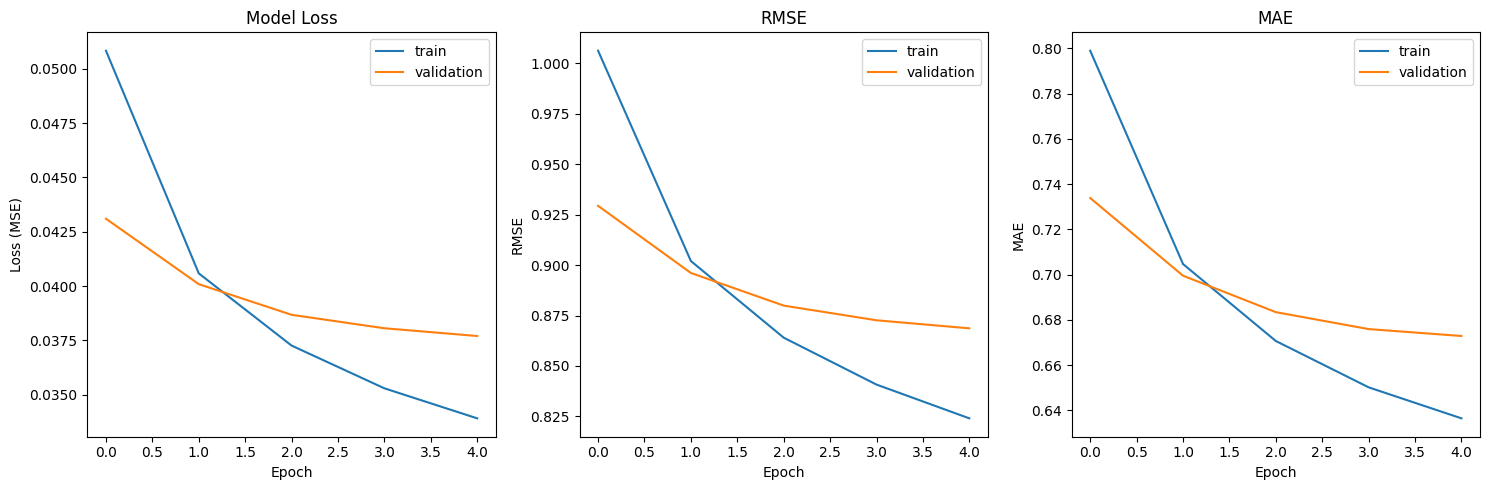


RMSE for Movies with high ratings from user: 0.4013
MAE for Movies with high ratings from user: 0.3454
RMSE for Top 20 movie recommendations: 0.3309
MAE for Top 20 movie recommendations: 0.3136

Showing recommendations for user: 601


,poster_path,tmdbId,title,genres,Predicted Rating,Actual Rating,Loss
81,,238.0,"Godfather, The (1972)",Crime|Drama,4.643572,5.0,-0.356428
92,,550.0,Fight Club (1999),Action|Crime|Drama|Thriller,4.591507,5.0,-0.408493
38,,289.0,Casablanca (1942),Drama|Romance,4.563818,4.0,0.563818
77,,278.0,"Shawshank Redemption, The (1994)",Crime|Drama,4.558897,5.0,-0.441103
76,,629.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.546115,5.0,-0.453885
9,,5925.0,"Great Escape, The (1963)",Action|Adventure|Drama|War,4.543508,4.5,0.043508
23,,129.0,Spirited Away (Sen to Chihiro no kamikakushi) (2001),Adventure|Animation|Fantasy,4.534699,5.0,-0.465301
45,,213.0,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,4.503600,4.5,0.003600
95,,85.0,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Action|Adventure,4.497435,4.0,0.497435
35,,424.0,Schindler's List (1993),Drama|War,4.483468,5.0,-0.516532



----
----
----
----
----
----
----
----


,poster_path,tmdbId,title,genres,Predicted Rating,Average Rating,Loss
897,,769.0,Goodfellas (1990),Crime|Drama,4.542805,4.250000,0.292805
890,,947.0,Lawrence of Arabia (1962),Adventure|Drama|War,4.536822,4.300000,0.236822
597,,935.0,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Comedy|War,4.536336,4.268041,0.268295
608,,627.0,Trainspotting (1996),Comedy|Crime|Drama,4.536206,4.039216,0.496990
4528,,4543.0,Monty Python's The Meaning of Life (1983),Comedy,4.536196,3.950000,0.586196
95,,103.0,Taxi Driver (1976),Crime|Drama|Thriller,4.515641,4.105769,0.409872
888,,429.0,"Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)",Action|Adventure|Western,4.509788,4.145833,0.363955
786,,11159.0,Secrets & Lies (1996),Drama,4.502594,4.590909,-0.088315
6634,,155.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.496798,4.238255,0.258543
933,,829.0,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,4.495877,4.211864,0.284013


In [ ]:
################################
# PART 3: COLLABORATIVE FILTERING
# V 1.1
################################

# Import necessary libraries
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import os
import random
from tqdm.notebook import tqdm
from IPython.display import display, HTML, Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import gdown

# Set seeds for reproducibility across all libraries
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Download MovieLens dataset
data_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
data_path = "ml-latest-small.zip"
!wget $data_url -O $data_path
!unzip -o $data_path

# Download TMDB dataset
if not os.path.exists("TMDB_all_movies.csv"):
    print("Downloading TMDB data file...")
    gdown.download('https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9',
                  'TMDB_all_movies.csv', quiet=False)

# Load all data files into pandas DataFrames
ratings_file = "ml-latest-small/ratings.csv"  # Contains user-movie ratings
movies_file = "ml-latest-small/movies.csv"    # Contains movie metadata
links_file = "ml-latest-small/links.csv"      # Contains external IDs
tmdb_file = "TMDB_all_movies.csv"             # TMDB movie data with posters

df = pd.read_csv(ratings_file)  # Main ratings dataframe
movies_df = pd.read_csv(movies_file)  # Movie information
links_df = pd.read_csv(links_file)    # External links
tmdb_df = pd.read_csv(tmdb_file)     # TMDB movie data

# Merge movies with links to get tmdbId for each movie
movies_df = pd.merge(movies_df, links_df, on='movieId', how='left')

# Preprocessing - Create mappings between original IDs and encoded indices
user_ids = df["userId"].unique().tolist()  # Get unique user IDs
user2user_encoded = {x: i for i, x in enumerate(user_ids)}  # Original ID → encoded index
userencoded2user = {i: x for i, x in enumerate(user_ids)}   # Encoded index → original ID

movie_ids = df["movieId"].unique().tolist()  # Get unique movie IDs
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}  # Original ID → encoded index
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}   # Encoded index → original ID

# Add encoded user and movie columns to dataframe
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

# Calculate dataset statistics
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)  # Convert ratings to float32
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

# SHUFFLE and SPLIT data into train/validation sets (90%/10%)
df = df.sample(frac=1, random_state=42)  # Shuffle entire dataframe
x = df[["user", "movie"]].values  # Features: user and movie indices
# Target: normalized ratings between 0-1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * df.shape[0])  # 90% for training
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Convert numpy arrays to PyTorch tensors with appropriate types
x_train = torch.LongTensor(x_train)  # User/movie indices must be long integers
y_train = torch.FloatTensor(y_train) # Ratings are floats
x_val = torch.LongTensor(x_val)
y_val = torch.FloatTensor(y_val)

# Create PyTorch Dataset class for MovieLens data
class MovieLensDataset(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users    # Tensor of user indices
        self.movies = movies  # Tensor of movie indices
        self.ratings = ratings # Tensor of normalized ratings

    def __len__(self):
        return len(self.ratings)  # Total number of samples

    def __getitem__(self, idx):
        # Returns tuple of (user_idx, movie_idx, rating) for given index
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Create Dataset and DataLoader instances for training and validation
train_dataset = MovieLensDataset(x_train[:, 0], x_train[:, 1], y_train)
val_dataset = MovieLensDataset(x_val[:, 0], x_val[:, 1], y_val)

batch_size = 64  # Number of samples per batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define embedding size for user/movie representations
EMBEDDING_SIZE = 50

# Deep Neural Network for Collaborative Filtering Model (DNNCF) Definition
class DNNCF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super(DNNCF, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # User embedding layer: maps user indices to dense vectors
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        # User bias term: single value per user
        self.user_bias = nn.Embedding(num_users, 1)

        # Movie embedding layer: maps movie indices to dense vectors
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        # Movie bias term: single value per movie
        self.movie_bias = nn.Embedding(num_movies, 1)

        # Multi-layer perceptron for learning interactions
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size * 2, 32),  # Input: concatenated user+movie embeddings
            nn.BatchNorm1d(32),  # Batch normalization
            nn.ReLU(),           # Activation function
            nn.Dropout(0.2),     # Dropout for regularization

            nn.Linear(32, 16),    # Hidden layer
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 8),    # Additional hidden layer
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Linear(8, 1)      # Output layer (single rating prediction)
        )

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        # Initialize embeddings with normal distribution
        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=np.sqrt(2.0 / self.embedding_size))
        nn.init.normal_(self.movie_embedding.weight, mean=0.0, std=np.sqrt(2.0 / self.embedding_size))
        # Initialize biases to zero
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        # Initialize MLP layers with initialization for ReLU
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, user_input, movie_input):
        # Get user and movie embeddings
        user_vector = self.user_embedding(user_input)  # shape: [batch_size, embedding_size]
        user_bias = self.user_bias(user_input).squeeze()  # shape: [batch_size]
        movie_vector = self.movie_embedding(movie_input)  # shape: [batch_size, embedding_size]
        movie_bias = self.movie_bias(movie_input).squeeze()  # shape: [batch_size]

        # Concatenate user and movie embeddings
        interaction = torch.cat([user_vector, movie_vector], dim=-1)  # shape: [batch_size, embedding_size*2]

        # Pass through MLP
        mlp_output = self.mlp(interaction).squeeze()  # shape: [batch_size]

        # Add user and movie biases
        x = mlp_output + user_bias + movie_bias  # shape: [batch_size]

        # Apply sigmoid to get prediction between 0-1
        return sigmoid(x)  # shape: [batch_size]

# Initialize model, loss function, and optimizer
model = DNNCF(num_users, num_movies, EMBEDDING_SIZE)
criterion = nn.MSELoss()  # Mean Squared Error loss

# Configure optimizer with different weight decays for different parameters
optimizer = optim.Adam([
    {'params': model.user_embedding.parameters(), 'weight_decay': 1e-5},  # L2 regularization
    {'params': model.movie_embedding.parameters(), 'weight_decay': 1e-5},
    {'params': model.user_bias.parameters(), 'weight_decay': 0},  # No regularization for biases
    {'params': model.movie_bias.parameters(), 'weight_decay': 0},
    {'params': model.mlp.parameters(), 'weight_decay': 1e-5}  # Regularization for MLP
], lr=0.001)  # Learning rate

# Training loop with loss tracking and metrics
train_losses = []
val_losses = []
train_rmses = []
val_rmses = []
train_maes = []
val_maes = []

def denormalize_ratings(normalized_ratings):
    """Convert normalized ratings back to original scale (1-5)"""
    return normalized_ratings * (max_rating - min_rating) + min_rating

for epoch in range(5):  # Train for 5 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_rmse = 0.0
    running_mae = 0.0

    # Wrap train_loader with tqdm for progress bar
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/5 [Training]', leave=False)

    for users, movies, ratings in train_iterator:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(users, movies)  # Forward pass
        loss = criterion(outputs, ratings)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Calculate metrics
        denorm_outputs = denormalize_ratings(outputs.detach().numpy())
        denorm_ratings = denormalize_ratings(ratings.detach().numpy())
        batch_rmse = sqrt(mean_squared_error(denorm_ratings, denorm_outputs))
        batch_mae = mean_absolute_error(denorm_ratings, denorm_outputs)

        # Accumulate metrics (multiply by batch size as we'll average later)
        running_loss += loss.item() * users.size(0)
        running_rmse += batch_rmse * users.size(0)
        running_mae += batch_mae * users.size(0)

        train_iterator.set_postfix(loss=loss.item(), rmse=batch_rmse, mae=batch_mae)  # Update progress bar

    # Calculate average epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_rmse = running_rmse / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_rmses.append(epoch_rmse)
    train_maes.append(epoch_mae)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_running_rmse = 0.0
    val_running_mae = 0.0

    # Wrap val_loader with tqdm for progress bar
    val_iterator = tqdm(val_loader, desc=f'Epoch {epoch+1}/5 [Validation]', leave=False)

    with torch.no_grad():  # Disable gradient calculation
        for users, movies, ratings in val_iterator:
            outputs = model(users, movies)
            loss = criterion(outputs, ratings)

            # Calculate validation metrics
            denorm_outputs = denormalize_ratings(outputs.numpy())
            denorm_ratings = denormalize_ratings(ratings.numpy())
            batch_rmse = sqrt(mean_squared_error(denorm_ratings, denorm_outputs))
            batch_mae = mean_absolute_error(denorm_ratings, denorm_outputs)

            val_running_loss += loss.item() * users.size(0)
            val_running_rmse += batch_rmse * users.size(0)
            val_running_mae += batch_mae * users.size(0)

            val_iterator.set_postfix(loss=loss.item(), rmse=batch_rmse, mae=batch_mae)

    # Calculate average validation metrics
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_rmse = val_running_rmse / len(val_loader.dataset)
    val_epoch_mae = val_running_mae / len(val_loader.dataset)

    val_losses.append(val_epoch_loss)
    val_rmses.append(val_epoch_rmse)
    val_maes.append(val_epoch_mae)

    print(f"Epoch {epoch+1}/5 - Train Loss: {epoch_loss:.4f} - Val Loss: {val_epoch_loss:.4f}")
    print(f"          Train RMSE: {epoch_rmse:.4f} - Val RMSE: {val_epoch_rmse:.4f}")
    print(f"          Train MAE: {epoch_mae:.4f} - Val MAE: {val_epoch_mae:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()

# RMSE plot
plt.subplot(1, 3, 2)
plt.plot(train_rmses, label='train')
plt.plot(val_rmses, label='validation')
plt.title('RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

# MAE plot
plt.subplot(1, 3, 3)
plt.plot(train_maes, label='train')
plt.plot(val_maes, label='validation')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Function to display dataframe with images
def display_with_images(df, title):
    display(HTML(f'<h1 style="background-color:red; color: white; padding: 5px 5px 5px 5px;">{title}</h1>'))

    if df.empty:
        display(HTML('<p>No recommendations found.</p>'))
        return

    # Create a new dataframe with image HTML
    display_df = df.copy()
    display_df['poster_path'] = display_df['poster_path'].apply(
        lambda x: f'<img src="{x}" width="100" height="150">'
    )

    # Display the dataframe with images
    display(HTML(display_df.to_html(escape=False)))

# Generate recommendations for user 601
user_id = 601

# TEST DATA
# user_id = 75
# user_id = 225
# user_id = 225
# user_id = 338
# user_id = 601

user_encoder = user2user_encoded.get(user_id)  # Get encoded index for user 601

# 1. Movies already rated by the user (watched movies)
movies_watched_by_user = df[df.userId == user_id].copy()
# Merge with movie metadata
movies_watched_by_user = pd.merge(movies_watched_by_user, movies_df, on='movieId', how='left')
# Merge with TMDB data to get poster paths
movies_watched_by_user = pd.merge(movies_watched_by_user, tmdb_df[['id', 'poster_path']],
                                 left_on='tmdbId', right_on='id', how='left')

# Prepare tensors for watched movies prediction
watched_user_tensor = torch.LongTensor([user_encoder] * len(movies_watched_by_user))  # Repeat user ID
watched_movie_tensor = torch.LongTensor(movies_watched_by_user['movie'].values)  # Movie indices

# Get predictions for watched movies
model.eval()
with torch.no_grad():
    predicted_ratings = model(watched_user_tensor, watched_movie_tensor).numpy().flatten()

# Denormalize ratings back to original scale (1-5)
predicted_ratings = predicted_ratings * (max_rating - min_rating) + min_rating
actual_ratings = movies_watched_by_user['rating'].values  # Actual ratings

# Create DataFrame for watched movies with predictions
watched_movies_df = movies_watched_by_user[['tmdbId', 'title', 'genres', 'poster_path']].copy()
watched_movies_df['Predicted Rating'] = predicted_ratings
watched_movies_df['Actual Rating'] = actual_ratings
watched_movies_df['Loss'] = watched_movies_df['Predicted Rating'] - watched_movies_df['Actual Rating']

# Process poster paths
watched_movies_df['poster_path'] = 'https://image.tmdb.org/t/p/w300_and_h450_bestv2/' + watched_movies_df['poster_path'].fillna('')
watched_movies_df['poster_path'] = watched_movies_df['poster_path'].replace(
    'https://image.tmdb.org/t/p/w300_and_h450_bestv2/',
    'https://critics.io/img/movies/poster-placeholder.png'
)

# Sort by predicted rating and select top 20
watched_movies_df = watched_movies_df.sort_values('Predicted Rating', ascending=False).head(20)

# 2. Calculate RMSE and MAE for watched movies predictions
rmse_watched = sqrt(mean_squared_error(watched_movies_df['Actual Rating'], watched_movies_df['Predicted Rating']))
mae_watched = mean_absolute_error(watched_movies_df['Actual Rating'], watched_movies_df['Predicted Rating'])
print(f"\nRMSE for Movies with high ratings from user: {rmse_watched:.4f}")
print(f"MAE for Movies with high ratings from user: {mae_watched:.4f}")

# 3. Get recommendations (movies not watched by user)
movies_not_watched = movies_df[~movies_df["movieId"].isin(movies_watched_by_user.movieId.unique())]
# Filter to only movies present in our encoding
movies_not_watched = movies_not_watched[movies_not_watched['movieId'].isin(movie2movie_encoded.keys())]
# Merge with TMDB data to get poster paths
movies_not_watched = pd.merge(movies_not_watched, tmdb_df[['id', 'poster_path']],
                             left_on='tmdbId', right_on='id', how='left')

# Prepare tensors for recommendation prediction
rec_user_tensor = torch.LongTensor([user_encoder] * len(movies_not_watched))  # Repeat user ID
rec_movie_tensor = torch.LongTensor(movies_not_watched['movieId'].map(movie2movie_encoded).values)  # Movie indices

# Get predicted ratings for all unwatched movies
model.eval()
with torch.no_grad():
    rec_predicted_ratings = model(rec_user_tensor, rec_movie_tensor).numpy().flatten()

# Denormalize predicted ratings
rec_predicted_ratings = rec_predicted_ratings * (max_rating - min_rating) + min_rating

# Get average ratings for these movies from the dataset
avg_ratings = df.groupby('movieId')['rating'].mean()
movies_not_watched['Average Rating'] = movies_not_watched['movieId'].map(avg_ratings)

# Create DataFrame for recommendations
recommendations_df = movies_not_watched[['tmdbId', 'title', 'genres', 'poster_path']].copy()
recommendations_df['Predicted Rating'] = rec_predicted_ratings
recommendations_df['Average Rating'] = movies_not_watched['Average Rating'].values
recommendations_df['Loss'] = recommendations_df['Predicted Rating'] - recommendations_df['Average Rating']

# Process poster paths
recommendations_df['poster_path'] = 'https://image.tmdb.org/t/p/w300_and_h450_bestv2/' + recommendations_df['poster_path'].fillna('')
recommendations_df['poster_path'] = recommendations_df['poster_path'].replace(
    'https://image.tmdb.org/t/p/w300_and_h450_bestv2/',
    'https://critics.io/img/movies/poster-placeholder.png'
)

# Sort by predicted rating and select top 20 recommendations
recommendations_df = recommendations_df.sort_values('Predicted Rating', ascending=False).head(20)

# 4. Calculate RMSE and MAE between predicted and average ratings for recommendations
rmse_rec = sqrt(mean_squared_error(recommendations_df['Average Rating'], recommendations_df['Predicted Rating']))
mae_rec = mean_absolute_error(recommendations_df['Average Rating'], recommendations_df['Predicted Rating'])
print(f"RMSE for Top 20 movie recommendations: {rmse_rec:.4f}")
print(f"MAE for Top 20 movie recommendations: {mae_rec:.4f}")

# Display results
print("\nShowing recommendations for user: {}".format(user_id))
print("====" * 9)
display_with_images(watched_movies_df[['poster_path', 'tmdbId', 'title', 'genres', 'Predicted Rating', 'Actual Rating', 'Loss']],
                   "Movies with high ratings from user")

print("\n----" * 8)
display_with_images(recommendations_df[['poster_path', 'tmdbId', 'title', 'genres', 'Predicted Rating', 'Average Rating', 'Loss']],
                   "Top 20 movie recommendations")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9
From (redirected): https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9&confirm=t&uuid=4d161946-d64e-44c8-9e2f-d930550f17ab
To: /content/TMDB_all_movies.csv
100%|██████████| 636M/636M [00:08<00:00, 70.8MB/s]


,id,title,genres,release_date,vote_average,score
16347,27205,Inception,"Action, Science Fiction, Adventure",2010-07-15,8.400,8.748025
183554,299536,Avengers: Infinity War,"Adventure, Action, Science Fiction",2018-04-25,8.200,8.319071
205617,324857,Spider-Man: Into the Spider-Verse,"Animation, Action, Adventure, Science Fiction",2018-12-06,8.400,8.263351
53707,76341,Mad Max: Fury Road,"Action, Adventure, Science Fiction",2015-05-13,7.600,8.031516
14443,24428,The Avengers,"Science Fiction, Action, Adventure",2012-04-25,7.729,7.951565
78061,118340,Guardians of the Galaxy,"Action, Science Fiction, Adventure",2014-07-30,7.905,7.944964
1151,1726,Iron Man,"Action, Science Fiction, Adventure",2008-04-30,7.600,7.845150
170445,284053,Thor: Ragnarok,"Action, Adventure, Science Fiction",2017-10-02,7.586,7.826502
82704,127585,X-Men: Days of Future Past,"Action, Adventure, Science Fiction",2014-05-15,7.529,7.819495
7805,13475,Star Trek,"Science Fiction, Action, Adventure",2009-05-06,7.427,7.803846


<ipython-input-4-7388f95cc558>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data.dropna(subset=[self.content_col], inplace=True)


,id,title,genres,dist
246428,374720,Dunkirk,"War, Action, Drama",0.796036
32943,49026,The Dark Knight Rises,"Action, Crime, Drama, Thriller",0.803394
96743,157336,Interstellar,"Adventure, Drama, Science Fiction",0.808273
846,1124,The Prestige,"Drama, Mystery, Science Fiction",0.827004
6629,11660,Following,"Drama, Thriller",0.828078
829041,1166326,Rainbow's Writing,"Comedy, Drama, Documentary",0.833067
224,272,Batman Begins,"Action, Crime, Drama",0.839930
405723,577922,Tenet,"Action, Thriller, Science Fiction",0.858306
624030,872585,Oppenheimer,"Drama, History",0.861864
116,155,The Dark Knight,"Drama, Action, Crime, Thriller",0.869819


--2025-05-15 15:29:09--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  5.96MB/s    in 0.2s    

2025-05-15 15:29:09 (5.96 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Epoch 1/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.0508 - Val Loss: 0.0431
          Train RMSE: 1.0062 - Val RMSE: 0.9294
          Train MAE: 0.7990 - Val MAE: 0.7339


Epoch 2/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.0406 - Val Loss: 0.0401
          Train RMSE: 0.9020 - Val RMSE: 0.8961
          Train MAE: 0.7047 - Val MAE: 0.6995


Epoch 3/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.0373 - Val Loss: 0.0387
          Train RMSE: 0.8640 - Val RMSE: 0.8799
          Train MAE: 0.6706 - Val MAE: 0.6834


Epoch 4/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.0353 - Val Loss: 0.0381
          Train RMSE: 0.8408 - Val RMSE: 0.8726
          Train MAE: 0.6502 - Val MAE: 0.6759


Epoch 5/5 [Training]:   0%|          | 0/1418 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.0339 - Val Loss: 0.0377
          Train RMSE: 0.8240 - Val RMSE: 0.8687
          Train MAE: 0.6364 - Val MAE: 0.6729


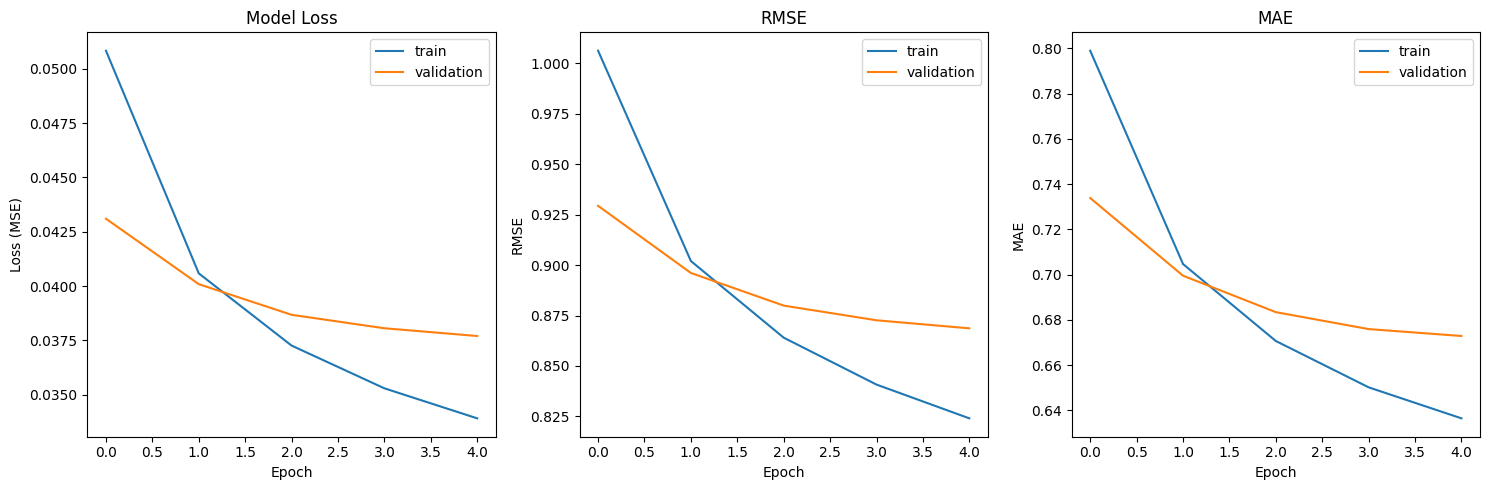


RMSE for Movies with high ratings from user: 0.4013
MAE for Movies with high ratings from user: 0.3454
RMSE for Top 20 movie recommendations: 0.3297
MAE for Top 20 movie recommendations: 0.3122



Showing recommendations for user: 601
Movies with high ratings from user
--------------------------------


,tmdbId,title,genres,Predicted Rating,Actual Rating,Loss
81,238.0,"Godfather, The (1972)",Crime|Drama,4.643572,5.0,-0.356428
92,550.0,Fight Club (1999),Action|Crime|Drama|Thriller,4.591507,5.0,-0.408493
38,289.0,Casablanca (1942),Drama|Romance,4.563818,4.0,0.563818
77,278.0,"Shawshank Redemption, The (1994)",Crime|Drama,4.558897,5.0,-0.441103
76,629.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.546115,5.0,-0.453885
9,5925.0,"Great Escape, The (1963)",Action|Adventure|Drama|War,4.543508,4.5,0.043508
23,129.0,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,4.534699,5.0,-0.465301
45,213.0,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,4.503600,4.5,0.003600
95,85.0,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.497435,4.0,0.497435
35,424.0,Schindler's List (1993),Drama|War,4.483468,5.0,-0.516532



----
----
----
----
----
----
----
----
Top 20 hybrid movie recommendations (filtered by demographic and content-based)
--------------------------------


,tmdbId,title,genres,Predicted Rating,Average Rating,Loss
914,769.0,Goodfellas (1990),Crime|Drama,4.542805,4.250000,0.292805
906,947.0,Lawrence of Arabia (1962),Adventure|Drama|War,4.536822,4.300000,0.236822
602,935.0,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.536336,4.268041,0.268295
613,627.0,Trainspotting (1996),Comedy|Crime|Drama,4.536206,4.039216,0.496990
4581,4543.0,Monty Python's The Meaning of Life (1983),Comedy,4.536196,3.950000,0.586196
98,103.0,Taxi Driver (1976),Crime|Drama|Thriller,4.515641,4.105769,0.409872
903,429.0,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,4.509788,4.145833,0.363955
796,11159.0,Secrets & Lies (1996),Drama,4.502594,4.590909,-0.088315
6710,155.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.496798,4.238255,0.258543
6710,155.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.496798,4.238255,0.258543


In [ ]:
#################################
# *** HYBRID VERSION ***
#################################

# Import all necessary libraries
!pip install gdown
import gdown
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_distances
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#######################################
# PART 1: DEMOGRAPHIC FILTERING
#######################################

# Download the dataset
gdown.download(f'https://drive.google.com/uc?export=download&id=1kXpT3KTqty5ZLrVHCK7gEE1KmsuqtiX9', quiet=False)

class DemographicRecommender:
    def __init__(self, data):
        self.df = pd.read_csv(data)

    def recommend(self, genre=None, duration=None, year=None, topk=50):
        df = self.df.copy()
        df_demographic_raw = self.demographic_filter(df, genre=genre, duration=duration, year=year)
        df_imdb_raw = self.compute_imdb_score(df_demographic_raw)
        result = df_imdb_raw
        df_demographic = df_demographic_raw.sort_values("vote_average", ascending=False).head(topk)
        df_imdb = result.sort_values("score", ascending=False).head(topk)
        df_pipeline_1 = result.sort_values("score", ascending=False).head(topk)
        return df_demographic, df_imdb, df_pipeline_1

    @staticmethod
    def demographic_filter(df, genre=None, duration=None, year=None):
        filtered_df = df.copy()
        if genre is not None:
            filtered_df = filtered_df[
                filtered_df['genres'].fillna('').apply(lambda x: all(g in x.split(', ') for g in genre))
            ]
        if duration is not None:
            filtered_df = filtered_df[
                filtered_df['runtime'].between(duration[0], duration[1])
            ]
        if year is not None:
            filtered_df = filtered_df[
                pd.to_datetime(filtered_df['release_date']).dt.year.between(year[0], year[1])
            ]
        return filtered_df

    @staticmethod
    def compute_imdb_score(df, percentile_threshold=0.95):
        df = df.copy()
        df = df.dropna(subset=['imdb_votes', 'imdb_rating'])
        m = np.percentile(df.imdb_votes, 80)
        C = (df.imdb_rating * df.imdb_votes).sum() / df.imdb_votes.sum()
        df = df[df.imdb_votes >= m]
        df["score"] = df.apply(lambda x: (x.imdb_rating * x.imdb_votes + C * m) / (x.imdb_votes + m), axis=1)
        return df

# Run demographic filtering
demographic_rec = DemographicRecommender("TMDB_all_movies.csv")
df_demographic, df_imdb, df_pipeline_1 = demographic_rec.recommend(
    genre=["Action", "Adventure", "Science Fiction"],
    duration=(60,150),
    year=(2000,2019)
)

display(HTML('<h1 style="background-color:red; color: white; padding: 5px 5px 5px 5px;">DEMOGRAPHIC FILTERING RESULTS</h1>'))
display(df_pipeline_1[['id', 'title', 'genres', 'release_date', 'vote_average', 'score']].head(10))

#######################################
# PART 2: CONTENT-BASED FILTERING
#######################################

class ContentBasedRecommender:
    def __init__(self, data, content_col):
        self.df = pd.read_csv(data)
        self.content_col = content_col
        self.encoder = None
        self.encoding = None

        if isinstance(self.content_col, list):
            self.df.dropna(subset=["title"] + self.content_col, inplace=True)
            self.df = self.df[~self.df[self.content_col].apply(lambda row: row.astype(str).str.strip().eq('').any(), axis=1)]
        else:
            self.df.dropna(subset=["title", self.content_col], inplace=True)
            self.df = self.df[self.df[self.content_col].str.strip().ne('')]

    def fit(self):
        if isinstance(self.content_col, list):
            self.df.dropna(subset=self.content_col, inplace=True)
            self.df = self.df[~self.df[self.content_col].apply(lambda row: row.astype(str).str.strip().eq('').any(), axis=1)]
            self.df['combined_content'] = self.df[self.content_col].apply(lambda x: ' '.join(x.astype(str)), axis=1)
            self.content_col = 'combined_content'
        else:
            self.df.dropna(subset=[self.content_col], inplace=True)
            self.df = self.df[self.df[self.content_col].str.strip().ne('')]

        self.encoder = TfidfVectorizer()
        self.encoding = self.encoder.fit_transform(self.df[self.content_col])

    def recommend(self, idx, topk=25):
        if idx not in self.df['id'].values:
            print(f"Movie ID {idx} not found in the dataset.")
            return pd.DataFrame()

        movie_data = self.df[self.df['id'] == idx]
        if isinstance(self.content_col, list):
            movie_data.dropna(subset=self.content_col, inplace=True)
            movie_data = movie_data[~movie_data[self.content_col].apply(lambda row: row.astype(str).str.strip().eq('').any(), axis=1)]
            content = movie_data[self.content_col].apply(lambda x: ' '.join(x.astype(str)), axis=1).iloc[0]
        else:
            movie_data.dropna(subset=[self.content_col], inplace=True)
            movie_data = movie_data[movie_data[self.content_col].str.strip().ne('')]
            content = movie_data[self.content_col].iloc[0]

        code = self.encoder.transform([content])
        dist = cosine_distances(code, self.encoding)
        rec_idx = dist.argsort()[0, 1:(topk + 1)]
        recommended_movies = self.df.iloc[rec_idx].copy()
        recommended_movies['dist'] = dist[0, rec_idx]
        df_content_based = recommended_movies
        df_pipeline_2 = recommended_movies
        return df_content_based, df_pipeline_2

    def get_movie_id_title_and_overview_from_search(self, search_title):
        search_title = search_title.lower()
        matching_titles = self.df[self.df['title'].str.lower().str.contains(search_title, na=False)]
        if not matching_titles.empty:
            return matching_titles[['id', 'title', 'overview']]
        else:
            return pd.DataFrame(columns=['id', 'title', 'overview'])

# Initialize with all SIGNIFICANT/IMPORTANT content columns
content_cols = ["title", "overview", "tagline", "genres", "production_companies", "cast", "director", "writers", "producers"]
content_rec = ContentBasedRecommender("TMDB_all_movies.csv", content_col=content_cols)
content_rec.fit()

# Get a movie from demographic results to use as seed
seed_movie_id = df_pipeline_1.iloc[0]['id']
df_content_based, df_pipeline_2 = content_rec.recommend(seed_movie_id)

# Merge with demographic results (remove duplicates)
df_pipeline_2 = pd.concat([df_pipeline_2[:10], df_pipeline_1[:10]])

display(HTML('<h1 style="background-color:red; color: white; padding: 5px 5px 5px 5px;">CONTENT-BASED FILTERING RESULTS (MERGED WITH DEMOGRAPHIC)</h1>'))
display(df_pipeline_2[['id', 'title', 'genres', 'dist']].head(20))

#######################################
# PART 3: COLLABORATIVE FILTERING
#######################################

# Download and prepare MovieLens dataset
data_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
data_path = "ml-latest-small.zip"
!wget $data_url -O $data_path
!unzip -o $data_path

# Load data
ratings_file = "ml-latest-small/ratings.csv"
movies_file = "ml-latest-small/movies.csv"
links_file = "ml-latest-small/links.csv"

df_ratings = pd.read_csv(ratings_file)
movies_df = pd.read_csv(movies_file)
links_df = pd.read_csv(links_file)

# Merge to get tmdbId
movies_df = pd.merge(movies_df, links_df, on='movieId', how='left')

# Create mappings
user_ids = df_ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df_ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# Add encoded columns
df_ratings["user"] = df_ratings["userId"].map(user2user_encoded)
df_ratings["movie"] = df_ratings["movieId"].map(movie2movie_encoded)

# Dataset statistics
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df_ratings["rating"] = df_ratings["rating"].values.astype(np.float32)
min_rating = min(df_ratings["rating"])
max_rating = max(df_ratings["rating"])

# Split data
df_ratings = df_ratings.sample(frac=1, random_state=42)
x = df_ratings[["user", "movie"]].values
y = df_ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * df_ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Convert to tensors
x_train = torch.LongTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.LongTensor(x_val)
y_val = torch.FloatTensor(y_val)

# Dataset class
class MovieLensDataset(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Create datasets and loaders
train_dataset = MovieLensDataset(x_train[:, 0], x_train[:, 1], y_train)
val_dataset = MovieLensDataset(x_val[:, 0], x_val[:, 1], y_val)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model definition
EMBEDDING_SIZE = 50

class DNNCF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super(DNNCF, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.movie_bias = nn.Embedding(num_movies, 1)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_size * 2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=np.sqrt(2.0 / self.embedding_size))
        nn.init.normal_(self.movie_embedding.weight, mean=0.0, std=np.sqrt(2.0 / self.embedding_size))
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, user_input, movie_input):
        user_vector = self.user_embedding(user_input)
        user_bias = self.user_bias(user_input).squeeze()
        movie_vector = self.movie_embedding(movie_input)
        movie_bias = self.movie_bias(movie_input).squeeze()
        interaction = torch.cat([user_vector, movie_vector], dim=-1)
        mlp_output = self.mlp(interaction).squeeze()
        x = mlp_output + user_bias + movie_bias
        return sigmoid(x)

# Initialize model and optimizer
model = DNNCF(num_users, num_movies, EMBEDDING_SIZE)
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.user_embedding.parameters(), 'weight_decay': 1e-5},
    {'params': model.movie_embedding.parameters(), 'weight_decay': 1e-5},
    {'params': model.user_bias.parameters(), 'weight_decay': 0},
    {'params': model.movie_bias.parameters(), 'weight_decay': 0},
    {'params': model.mlp.parameters(), 'weight_decay': 1e-5}
], lr=0.001)

# Training loop with RMSE/MAE tracking
train_losses = []
val_losses = []
train_rmses = []
val_rmses = []
train_maes = []
val_maes = []

def denormalize_ratings(normalized_ratings):
    """Convert normalized ratings back to original scale (1-5)"""
    return normalized_ratings * (max_rating - min_rating) + min_rating

for epoch in range(5):
    model.train()
    running_loss = 0.0
    running_rmse = 0.0
    running_mae = 0.0

    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/5 [Training]', leave=False)

    for users, movies, ratings in train_iterator:
        optimizer.zero_grad()
        outputs = model(users, movies)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        # Calculate metrics on denormalized ratings
        denorm_outputs = denormalize_ratings(outputs.detach().numpy())
        denorm_ratings = denormalize_ratings(ratings.detach().numpy())
        batch_rmse = sqrt(mean_squared_error(denorm_ratings, denorm_outputs))
        batch_mae = mean_absolute_error(denorm_ratings, denorm_outputs)

        running_loss += loss.item() * users.size(0)
        running_rmse += batch_rmse * users.size(0)
        running_mae += batch_mae * users.size(0)

        train_iterator.set_postfix(loss=loss.item(), rmse=batch_rmse, mae=batch_mae)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_rmse = running_rmse / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_rmses.append(epoch_rmse)
    train_maes.append(epoch_mae)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_rmse = 0.0
    val_running_mae = 0.0

    val_iterator = tqdm(val_loader, desc=f'Epoch {epoch+1}/5 [Validation]', leave=False)

    with torch.no_grad():
        for users, movies, ratings in val_iterator:
            outputs = model(users, movies)
            loss = criterion(outputs, ratings)

            # Calculate validation metrics
            denorm_outputs = denormalize_ratings(outputs.numpy())
            denorm_ratings = denormalize_ratings(ratings.numpy())
            batch_rmse = sqrt(mean_squared_error(denorm_ratings, denorm_outputs))
            batch_mae = mean_absolute_error(denorm_ratings, denorm_outputs)

            val_running_loss += loss.item() * users.size(0)
            val_running_rmse += batch_rmse * users.size(0)
            val_running_mae += batch_mae * users.size(0)

            val_iterator.set_postfix(loss=loss.item(), rmse=batch_rmse, mae=batch_mae)

    # Calculate validation epoch metrics
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_rmse = val_running_rmse / len(val_loader.dataset)
    val_epoch_mae = val_running_mae / len(val_loader.dataset)

    val_losses.append(val_epoch_loss)
    val_rmses.append(val_epoch_rmse)
    val_maes.append(val_epoch_mae)

    print(f"Epoch {epoch+1}/5 - Train Loss: {epoch_loss:.4f} - Val Loss: {val_epoch_loss:.4f}")
    print(f"          Train RMSE: {epoch_rmse:.4f} - Val RMSE: {val_epoch_rmse:.4f}")
    print(f"          Train MAE: {epoch_mae:.4f} - Val MAE: {val_epoch_mae:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()

# RMSE plot
plt.subplot(1, 3, 2)
plt.plot(train_rmses, label='train')
plt.plot(val_rmses, label='validation')
plt.title('RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

# MAE plot
plt.subplot(1, 3, 3)
plt.plot(train_maes, label='train')
plt.plot(val_maes, label='validation')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

#######################################
# HYBRID RECOMMENDATION GENERATION
#######################################

def generate_hybrid_recommendations(user_id, model, df_ratings, movies_df, df_pipeline_2, topk=20):
    # Get encoded user ID
    user_encoder = user2user_encoded.get(user_id)
    if user_encoder is None:
        print(f"User ID {user_id} not found in the dataset.")
        return None, None

    # 1. Get movies already watched by the user
    movies_watched_by_user = df_ratings[df_ratings.userId == user_id].copy()
    movies_watched_by_user = pd.merge(movies_watched_by_user, movies_df, on='movieId', how='left')

    # Prepare tensors for watched movies prediction
    watched_user_tensor = torch.LongTensor([user_encoder] * len(movies_watched_by_user))
    watched_movie_tensor = torch.LongTensor(movies_watched_by_user['movie'].values)

    # Get predictions for watched movies
    model.eval()
    with torch.no_grad():
        predicted_ratings = model(watched_user_tensor, watched_movie_tensor).numpy().flatten()

    # Denormalize ratings
    predicted_ratings = predicted_ratings * (max_rating - min_rating) + min_rating
    actual_ratings = movies_watched_by_user['rating'].values

    # Create DataFrame for watched movies with predictions
    watched_movies_df = movies_watched_by_user[['tmdbId', 'title', 'genres']].copy()
    watched_movies_df['Predicted Rating'] = predicted_ratings
    watched_movies_df['Actual Rating'] = actual_ratings
    watched_movies_df['Loss'] = watched_movies_df['Predicted Rating'] - watched_movies_df['Actual Rating']
    watched_movies_df = watched_movies_df.sort_values('Predicted Rating', ascending=False).head(topk)

    # 2. Get movies not watched by the user (filtered by our pipeline)
    movies_not_watched = movies_df[~movies_df["movieId"].isin(movies_watched_by_user.movieId.unique())]
    movies_not_watched = movies_not_watched[movies_not_watched['movieId'].isin(movie2movie_encoded.keys())]
    pipeline_movie_ids = df_pipeline_2['id'].tolist()

    movies_not_watched = pd.concat([movies_not_watched, movies_not_watched[movies_not_watched['tmdbId'].isin(pipeline_movie_ids)]])

    # Prepare tensors for recommendation prediction
    rec_user_tensor = torch.LongTensor([user_encoder] * len(movies_not_watched))
    rec_movie_tensor = torch.LongTensor(movies_not_watched['movieId'].map(movie2movie_encoded).values)

    # Get predicted ratings for unwatched movies
    model.eval()
    with torch.no_grad():
        rec_predicted_ratings = model(rec_user_tensor, rec_movie_tensor).numpy().flatten()

    # Denormalize predicted ratings
    rec_predicted_ratings = rec_predicted_ratings * (max_rating - min_rating) + min_rating

    # Get average ratings for these movies
    avg_ratings = df_ratings.groupby('movieId')['rating'].mean()
    movies_not_watched['Average Rating'] = movies_not_watched['movieId'].map(avg_ratings)

    # Create DataFrame for recommendations
    recommendations_df = movies_not_watched[['tmdbId', 'title', 'genres']].copy()
    recommendations_df['Predicted Rating'] = rec_predicted_ratings
    recommendations_df['Average Rating'] = movies_not_watched['Average Rating'].values
    recommendations_df['Loss'] = recommendations_df['Predicted Rating'] - recommendations_df['Average Rating']
    recommendations_df = recommendations_df.sort_values('Predicted Rating', ascending=False).head(topk)

    # Calculate RMSE and MAE for both watched and recommended movies
    rmse_watched = sqrt(mean_squared_error(watched_movies_df['Actual Rating'], watched_movies_df['Predicted Rating']))
    mae_watched = mean_absolute_error(watched_movies_df['Actual Rating'], watched_movies_df['Predicted Rating'])

    rmse_rec = sqrt(mean_squared_error(recommendations_df['Average Rating'], recommendations_df['Predicted Rating']))
    mae_rec = mean_absolute_error(recommendations_df['Average Rating'], recommendations_df['Predicted Rating'])

    print(f"\nRMSE for Movies with high ratings from user: {rmse_watched:.4f}")
    print(f"MAE for Movies with high ratings from user: {mae_watched:.4f}")
    print(f"RMSE for Top {topk} movie recommendations: {rmse_rec:.4f}")
    print(f"MAE for Top {topk} movie recommendations: {mae_rec:.4f}")

    return watched_movies_df, recommendations_df

# Generate hybrid recommendations for user 601
user_id = 601

# TEST DATA
# user_id = 75
# user_id = 225
# user_id = 225
# user_id = 338
# user_id = 601

watched_movies_df, recommendations_df = generate_hybrid_recommendations(
    user_id, model, df_ratings, movies_df, df_pipeline_2)

# Display results
display(HTML('<h1 style="background-color:red; color: white; padding: 5px 5px 5px 5px;">FINAL HYBRID RECOMMENDATIONS</h1>'))
print("\nShowing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
display(watched_movies_df[['tmdbId', 'title', 'genres', 'Predicted Rating', 'Actual Rating', 'Loss']])

print("\n----" * 8)
print(f"Top 20 hybrid movie recommendations (filtered by demographic and content-based)")
print("----" * 8)
display(recommendations_df[['tmdbId', 'title', 'genres', 'Predicted Rating', 'Average Rating', 'Loss']])

